# Mutl-Level Product Categorisation

Date: 22.12.2021 <br>
by: Mohamed Gutale

## 1. Introduction

This is a retail project which aims to categorise multi-level products into categories automaticaly by using machine learning. Getting the correct product categorisation is a very important step for online retailers. In the old days, the categorisation was done manually which used to take a tremendous amount of time and resource however in todays modern technology, many online retailer employ machine learning techniques to automate this process. 

## 2. Problem Definition

### 2.1 Task Definition

In this task, i will be implementing a product categoriser by classifying level 1 category first then level 2 and finally level 3. I therefore will be creating many models and saving them to pickle and then calling on these models to make predictions.  

### 2.2 Data Cleaning & Processing

The intial dataset contains 10k observations with one column as text data describing the product and 3 columns containing the target variables in thise case 3 categories. As this data contains text data i will be performing a lot of natural language processing tasks to get the data into numeric data fit for machine learning.  

The structure of this notebook will following the following steps:

- Import required libraries 
- Load the dataset and performing initial exploration
- Clean and Process
- Extract Features
- Visualise words
- Split data into Train & Test
- Train models 
- Test Models
- Evaluate Accuracy

### 2.3 Dataset

The file size containing the dataset is 2.3MB and contains 10,649 observations and 4 columns.  The first column contains the description of the products in text datatype and the last 3 columns contain the labels for each level category. As the file is too large for the current memory of this laptop in order to perform the bags of words, i will select a subset of the data.   

### 2.4 Evaluation 

After the models are created, i will be expecting to acheive around the 80% mark.  

## 3. Main Body

### 3.1 Import Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem import PorterStemmer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from collections import defaultdict

### 3.2 Load and Explore 

In [2]:
df = pd.read_csv('product-cat-dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649 entries, 0 to 10648
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  10637 non-null  object
 1   Level_1      10649 non-null  object
 2   Level_2      10649 non-null  object
 3   Level_3      10649 non-null  object
dtypes: object(4)
memory usage: 332.9+ KB


In [4]:
df.sample(10)

,Description,Level_1,Level_2,Level_3
6818,cross pend sterl silv cross pend includ 18 inc...,96F95EEC,36080,C563
1092,huggy sensit baby wip soft gentl hypoallergeni...,4C3D8686,74974,62E8
6582,soft laid back look joe joe box wom hoody jack...,57164AC1,94728,5912
6060,button closurev neckembroid print,35E04739,390F1,6856
1335,two replac silicon nippl exclud dr brown nat f...,69286F45,2D5A3,28A7
8633,pres 120 simpl prep tim sav recip quick easy m...,B092BA29,5A8AB,AA6B
5206,bring bas button vint heath look adam levin me...,4513C920,F4055,1F75
7876,amol capacit touchscreen 16m col 480 x 854 pix...,09BF5150,5E038,6BE5
4941,look smart wom striped shirt covington tripl d...,2CEC27F1,BAE8A,2ABA
2991,keep warm work ins duck workvest heavy duty we...,57164AC1,7B638,0F8B


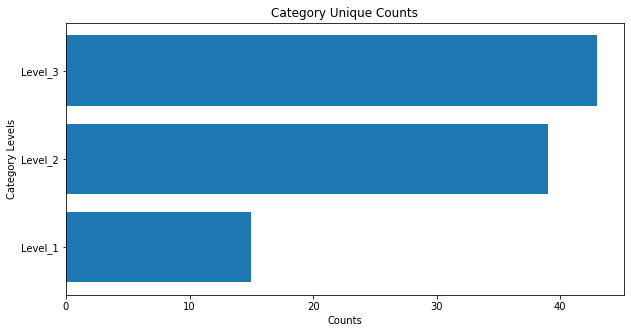

In [5]:
# count the number of unique classes in each category Level
cat = []
values = []
for col in df.columns[1:]:
    cat.append(col)
    values.append(df[col].unique().size)
    
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(cat, values)
plt.title('Category Unique Counts')
plt.ylabel('Category Levels')
plt.xlabel('Counts')
plt.show()

Level1 seems to be the most generic and Level3 the most specific and therefore the highest count.

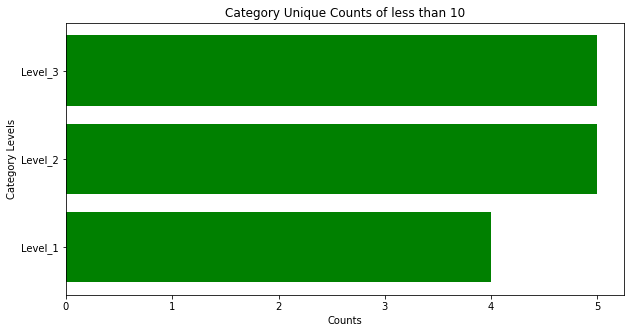

In [6]:
# Check if there are classes with instances less than 10
indexes = []

#subset to 'Levels column'
for col in df.columns[1:]:
    #subset to categories in wach Level and search for values < 10 and append index to indexes list
    for index, value in df[col].value_counts().items():
        if value < 10:
            indexes.append(df[df[col] == index].index.tolist())

indexes = [item for sublist in indexes for item in sublist]
df_ = df.loc[indexes,:]

# count the number of unique classes in each category Level
cat = []
values = []
for col in df_.columns[1:]:
    cat.append(col)
    values.append(df_[col].unique().size)
    
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(cat, values, color = 'g')
plt.title('Category Unique Counts of less than 10')
plt.ylabel('Category Levels')
plt.xlabel('Counts')
plt.show()

### 3.3 Clean and Process

In [7]:
#drop categories that are less than 10
df.drop(df_.index.tolist(), inplace = True)

In [8]:
# check for duplicates
df.duplicated().sum()

937

In [9]:
# drop the duplicates
df.drop_duplicates(inplace = True)

In [10]:
# check if data has missing values
df.isnull().sum()

Description    6
Level_1        0
Level_2        0
Level_3        0
dtype: int64

In [11]:
# drop rows with missing values
df.dropna(how = 'any', inplace = True)

In [12]:
#seperate labels from the feature section
labels = df.drop('Description', axis = 1)
feature = df['Description']

In [13]:
#download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mogutale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#define function for processing text data and return tokenised clean text
def process_text(doc):
    """
    Takes in a string of text, then performs the following:
    1. Convert text to lower case 
    2. Remove all punctuation
    3. Remove numbers
    4. Remove stop-words
    5. stem words
    6. Remove words less than 3 charectors
    7. Returns the tokenised texts
    """
    
    # lower text on each row 
    doc = doc.transform(lambda x: x.lower())
    
    # remove puncuations 
    doc = doc.transform(lambda x: re.sub('['+punctuation+']', '', x))
    
    # remove numbers
    doc = doc.transform(lambda x: re.sub('[0-9]+', '', x))
    
    #Remove stop words
    doc = doc.transform(lambda x: ' '.join([word for word in x.split(' ') if word not in (stop_words)]))
    
    #stem words
    ps = PorterStemmer()
    doc = doc.transform(lambda x:' '.join((ps.stem(word) for word in x.split(' '))))
    
    #remove words less than 3 charectors
    doc = doc.transform(lambda x: ' '.join([word for word in x.split(' ') if len(word) > 2]))
    
    #remove white space
    doc = doc.transform(lambda x: x.strip())
    
    return doc

In [16]:
# clean the text
feature_cleaned = process_text(feature)

#preview the clean text
feature_cleaned.sample(10)

6967    disney aladdin namepl larg sterl silv jasmin n...
8266    find instruct inspir art improv paint demonst ...
4295    dark fin giv wom skinni jean nick mina modern ...
8432    bread machin cookbook hand shap bread dough cy...
1233    produc informationluv ultr cle wip pillowi bum...
3951    new collect old favorit built found tradit wor...
9845    pol provid flawless cov along outstand dur chi...
3775    subtl shim stripe throughout laur scot wom swe...
7078    beauti sterl silv diamond pend sleek styl ster...
5464    get gre solid styl covington men shirt class n...
Name: Description, dtype: object

### 3.4 Sample the dataset

In [17]:
#random sample 
sample_feat = feature_cleaned.sample(3000)
sample_label = labels.loc[sample_feat.index.tolist()]

#reset index
sample_feat.reset_index(drop = True, inplace = True)
sample_label.reset_index(drop = True, inplace = True)

### 3.5 Feature Extraction

In [20]:
# Now let's apply TF-IDF to extract features from plain text including ngrams of up to 3 words
tfidfvectorizer = TfidfVectorizer(ngram_range=(1,3))
tfidfvectors = tfidfvectorizer.fit_transform(sample_feat)

#feature names
tfidffeature_names = tfidfvectorizer.get_feature_names_out()

#extract feature values
tfidfdense = tfidfvectors.todense()
tfidfdenselist = tfidfdense.tolist()

# Load to df
sample_feat= pd.DataFrame(tfidfdenselist, columns=tfidffeature_names)

#print head
sample_feat.head()

,aainsid,aainsid find,aainsid find mouthw,aand,aand cut,aand cut back,aarp,aarp facebookauth,aarp facebookauth col,abl,...,zucchin gre,zucchin gre delici,zucchin recip,zucchin recip frank,zucchin recip top,zutano,zutano husband,zutano husband wif,zutano sail,zutano sail shirt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.6 Visualise Top 100 WordCloud

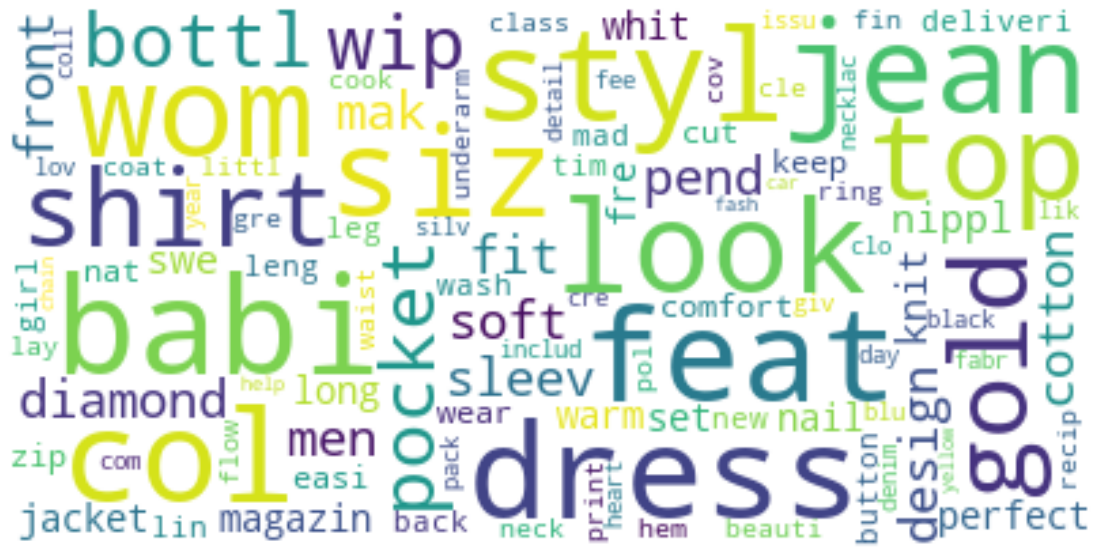

In [21]:
#transpose and sum values for each axis
x = sample_feat.T.sum(axis = 1)
cloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(x)

# Display the generated image
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
cloud.to_file("product_category_wordcloud.png")
plt.show()

### 3.7 Train Test Split

In [22]:
# Train/Test split and maintain class balance with stratify
X_train, X_test, y_train, y_test = train_test_split(sample_feat, sample_label, test_size=0.33, random_state=42, stratify = sample_label)

### 3.8 Train Model

In [25]:
# Create and save model for level 1
import pickle
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train.values, y_train['Level_1'])
with open('level1_model', 'wb') as f:
    pickle.dump(model, f)

In [26]:
## Create and save models for level 2
import numpy as np
unique_classes = np.unique(y_train['Level_1'])

models = []

for clas in unique_classes:
    y_train_model2 = y_train[y_train['Level_1'] == clas].Level_2
    X_train_model2 = X_train.loc[y_train_model2.index.tolist()]
    model = MultinomialNB()
    model.fit(X_train_model2.values, y_train_model2)
    models.append((f'{clas}', model))
    
with open("level2_models.pckl", "wb") as f:
    for model in models:
         pickle.dump(model, f)

In [27]:
## Create and save models for level 3
unique_classes = np.unique(y_train['Level_2'])

models = []

for clas in unique_classes:
    y_train_model3 = y_train[y_train['Level_2'] == clas].Level_3
    X_train_model3 = X_train.loc[y_train_model3.index.tolist()]
    model = MultinomialNB()
    model.fit(X_train_model3.values, y_train_model3)
    models.append((f'{clas}', model))
    
with open("level3_models.pckl", "wb") as f:
    for model in models:
         pickle.dump(model, f)

### 3.9 Predict the testset

In [28]:
## Here we reload the saved models and use them to predict the levels

# load model for level 1 
with open('level1_model', 'rb') as f:
    model_1 = pickle.load(f)

# load model for level 2
level2_models = []

with open("level2_models.pckl", "rb") as f:
    while True:
        try:
            level2_models.append(pickle.load(f))
        except Exception as er:
            break

# load model for level 3
level3_models = []

with open("level3_models.pckl", "rb") as f:
    while True:
        try:
            level3_models.append(pickle.load(f))
        except Exception as er:
            break

In [29]:
# Creating an empty Dataframe with column names only
results = pd.DataFrame(columns=['Level1_Pred', 'Level2_Pred', 'Level3_Pred'])

for result in results.columns:
    #empty lists for predictions
    level1_preds = []
    level2_preds = []
    level3_preds = []
    
    # level 1 predictions
    level1_preds.append(model_1.predict(X_test.values))
    #flatten the list
    level1_preds = [item for sublist in level1_preds for item in sublist]
    #append to X_test
    X_test['Level1_Pred'] = level1_preds
    
    #level 2 predictions
    for index, value in X_test.iterrows():
        for cat, model in level2_models:
            if cat == value['Level1_Pred']:
                level2_preds.append(model.predict(value.drop(['Level1_Pred']).values.reshape(1,-1)))
    #flatten the list            
    level2_preds = [item for sublist in level2_preds for item in sublist]
    #append to X_test
    X_test['Level2_Pred'] = level2_preds
    #remove level1 predictions
    X_test.drop('Level1_Pred', axis = 1, inplace = True)
    
    #level 3 predictions
    for index, value in X_test.iterrows():
        for cat, model in level3_models:
            if cat == value['Level2_Pred']:
                level3_preds.append(model.predict(value.drop(['Level2_Pred']).values.reshape(1,-1)))
    #flatten the list            
    level3_preds = [item for sublist in level3_preds for item in sublist] 
    #remove the level 2 predictions from X_test
    X_test.drop('Level2_Pred', axis = 1, inplace = True)
    
## Results in dataframe
results['Level1_Pred'] = [item for item in level1_preds]
results['Level2_Pred'] = [item for item in level2_preds]
results['Level3_Pred'] = [item for item in level3_preds]

In [30]:
results

,Level1_Pred,Level2_Pred,Level3_Pred
0,35E04739,390F1,6856
1,69286F45,2D5A3,28A7
2,96F95EEC,A04D3,C5B4
3,57164AC1,94728,5912
4,3E1E0D78,9D9EE,05A0
...,...,...,...
985,AAC8EE56,914A1,D97D
986,4C3D8686,74974,62E8
987,4C3D8686,74974,62E8
988,96F95EEC,A04D3,C5B4


### 4.0 Compute Accuracy on each level 
Now you have the predictions for each level (in the test data), and you also have the actual levels, you can compute the accurcay

In [31]:
# Level 1 accuracy
accuracy_score(y_test['Level_1'], results['Level1_Pred'])

0.7616161616161616

In [32]:
# Level 2 accuracy
accuracy_score(y_test['Level_2'], results['Level2_Pred'])

0.6414141414141414

In [33]:
# Level 3 accuracy
accuracy_score(y_test['Level_3'], results['Level3_Pred'])

0.6414141414141414